In [1]:
#Libraries to Import
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#These in which we carried out feature engineering.
X_train = pd.read_csv('x_train.csv')
X_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
#Defining the target df as just the 'TARGET' column
y_train_clean = y_train['TARGET']

In [4]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_clean, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost regression
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define hyperparameters for XGBoost regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Train the XGBoost model for regression
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'validation')], early_stopping_rounds=10)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Evaluate the model using Spearman correlation
spearman_corr = spearmanr(y_pred, y_val).correlation
print(f"Validation Spearman correlation: {spearman_corr}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:50:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:1.09099
[1]	validation-rmse:1.08954
[2]	validation-rmse:1.08701
[3]	validation-rmse:1.08497
[4]	validation-rmse:1.08283
[5]	validation-rmse:1.08138
[6]	validation-rmse:1.08120
[7]	validation-rmse:1.07930
[8]	validation-rmse:1.07929
[9]	validation-rmse:1.07976
[10]	validation-rmse:1.08083
[11]	validation-rmse:1.08246
[12]	validation-rmse:1.08176
[13]	validation-rmse:1.08236
[14]	validation-rmse:1.08295
[15]	validation-rmse:1.08437
[16]	validation-rmse:1.08417
[17]	validation-rmse:1.08456
[18]	validation-rmse:1.08655
Validation Spearman correlation: 0.1672409094385797


#Hyperparameter Optimization

In [5]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define hyperparameter grid for Grid Search
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'seed': [42]
}

# Create an XGBoost model
model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=None)

# Fit the grid search to the data
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_result.best_params_)


Best Parameters:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'objective': 'reg:squarederror', 'seed': 42}


#MAE and MSE

In [6]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

best_params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 42}

# Create and train the XGBoost model with the best parameters
final_model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])
y_train_pred = final_model.predict(dtrain)

# Flatten the 2D arrays
y_true_flat = y_train.values.ravel()
y_pred_flat = y_train_pred.ravel()

# Calculate MAE
mae = mean_absolute_error(y_true_flat, y_pred_flat)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 0.5315367632640877
Mean Squared Error (MSE): 0.8950449310629931


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:51:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


#Test Prediction

In [7]:
# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Make predictions on the test set
y_test_pred = final_model.predict(dtest)

# Create a DataFrame with "ID" and "Target" columns
result_df = pd.DataFrame({'ID': X_test['ID'], 'TARGET': y_test_pred})

# Export the predictions to a CSV file
result_df.to_csv('predictions.csv', index=False)


#Feature Importance

In [8]:
# Get feature importances using get_score()
feature_importance_dict = final_model.get_score(importance_type='weight')

# Normalize the importance scores
total_importance = sum(feature_importance_dict.values())
normalized_importance_dict = {feature: importance / total_importance for feature, importance in feature_importance_dict.items()}

# Print or use the normalized feature importance dictionary as needed
print("Feature Importance:")
for feature, importance in normalized_importance_dict.items():
    print(f"{feature}: {importance}")

Feature Importance:
ID: 0.11428571428571428
DE_CONSUMPTION: 0.09285714285714286
FR_CONSUMPTION: 0.012857142857142857
DE_NET_IMPORT: 0.025714285714285714
FR_NET_IMPORT: 0.017142857142857144
DE_GAS: 0.03142857142857143
FR_GAS: 0.10285714285714286
DE_COAL: 0.014285714285714285
FR_COAL: 0.03428571428571429
DE_HYDRO: 0.02
FR_HYDRO: 0.002857142857142857
DE_SOLAR: 0.02857142857142857
FR_SOLAR: 0.004285714285714286
DE_WINDPOW: 0.05142857142857143
FR_WINDPOW: 0.014285714285714285
DE_LIGNITE: 0.05
DE_RESIDUAL_LOAD: 0.06
FR_RESIDUAL_LOAD: 0.015714285714285715
DE_RAIN: 0.008571428571428572
FR_RAIN: 0.008571428571428572
FR_TEMP: 0.04428571428571428
GAS_RET: 0.08571428571428572
CARBON_RET: 0.05142857142857143
DE_WIND_EXCESS: 0.01
FR_WIND_EXCESS: 0.06857142857142857
FR_OVERCON: 0.03


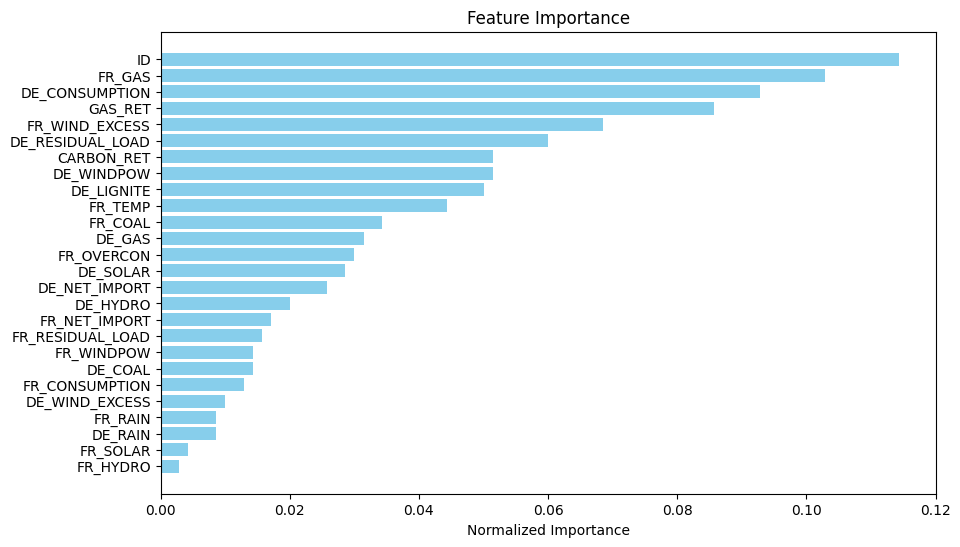

In [ ]:
# Normalize the importance scores
total_importance = sum(feature_importance_dict.values())
normalized_importance_dict = {feature: importance / total_importance for feature, importance in feature_importance_dict.items()}

# Sort features by importance
sorted_importance = sorted(normalized_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Extract sorted feature names and importance scores
sorted_features, sorted_importances = zip(*sorted_importance)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Normalized Importance')
plt.title('Feature Importance')
plt.show()